In [1]:
import sys
sys.path.append('functions/')
import pandas as pd
import numpy as np
import griess as gr
import bmgdata as bd
import matplotlib.pyplot as plt
import glob
import denitfit as dn
import pickle

#define function to process metabolite data
def load_plate_timeseries_no_OD(meta_fn,no2_fns,no2no3_540_fns,no2no3_900_fns,fit,pidx):
    plate_meta = pd.read_csv(meta_fn,index_col=0).dropna()  #import metadata and drop rows with any empty elements
    #reads in files and infers concentrations from absorbances using standard curve parameters ("fit")
    #assumes filenames are in the order t1, t2, t3, ...
    plate_no2 = pd.DataFrame()
    plate_no3 = pd.DataFrame()
    for i in range(0,len(no2_fns)):
        no2 = gr.read_griess(meta_fn,data_fn=no2_fns[i])
        if no2no3_540_fns == None:
            no2no3 = None
        else:
            no2no3 = gr.read_griess(meta_fn,data_540_fn=no2no3_540_fns[i],data_900_fn=no2no3_900_fns[i])
        data = gr.invert_griess(no2,fit,no2no3)
        plate_no2 = plate_no2.append(data["NO2"].rename("t"+str(i+1)))
        plate_no3 = plate_no3.append(data["NO3"].rename("t"+str(i+1)))
    
    #adds a prefix to the column names to indicate what plate the sample belongs to
    plate_meta  = ((plate_meta.transpose()).add_prefix("p" + str(pidx) + "_")).transpose()
    plate_no2 = plate_no2.add_prefix("p" + str(pidx) + "_")
    plate_no3 = plate_no3.add_prefix("p" + str(pidx) + "_")
    
    #transposes data frame so columns are time points and rows are wells
    plate_no2 = plate_no2.transpose()
    plate_no3 = plate_no3.transpose()
    
    return [plate_meta,plate_no2,plate_no3]

In [2]:

#load OD data and metadata
meta_fn = "data/plate1_metadata_cycle1.csv"
OD_filename = 'data/KC_OD600_Greiner_KC_NarG_NapA_co_vs_mono_cycle2_endpoint_1300_220513_131512.csv'
OD_meta       = pd.read_csv(meta_fn,index_col=0).dropna(how='all')  #import metadata
OD_data_frame = bd.read_abs_endpoint(OD_filename)
OD_data_frame = OD_data_frame[OD_data_frame.index.isin(OD_meta.index)]

all_IDs = list(set(OD_meta["strain_ID"].values))
blank_idx = (OD_meta["strain_ID"] == "blank")
blanks = OD_data_frame[blank_idx].values
pH = 6.0

#associate genotypes with strain names manually
IDs_orig = ['PDM21', 'PDM10', 'XNM01', 'PDM04', 'PXM04', 'RHZ02', 'CMM02']
genotypes_orig = ['NarG', 'NarG', 'NapA', 'NarG', 'NapA', 'NapA', 'NapA']


genotypes_orig = [genotypes for _,genotypes in sorted(zip(IDs_orig,genotypes_orig))]
IDs_orig = np.sort(IDs_orig)


IDs = ['PDM21', 'PDM10', 'XNM01', 'PDM04', 'PXM04', 'RHZ02', 'CMM02']
genotypes = ['NarG', 'NarG', 'NapA', 'NarG', 'NapA', 'NapA', 'NapA']

IDs_cos = []

#find coculture IDs 
for i in range(len(all_IDs)):
    if '+' in all_IDs[i]:
        IDs.append(all_IDs[i])
        IDs_cos.append(all_IDs[i])
        genotypes.append('NarG+NapA')
genotypes = [genotypes for _,genotypes in sorted(zip(IDs,genotypes))]
IDs = np.sort(IDs)
IDs_w_blanks = np.append(IDs, ['blank','cells'])
genotypes_w_blanks = np.append(genotypes, ['control', 'control'])
IDs_cos = np.sort(IDs_cos)





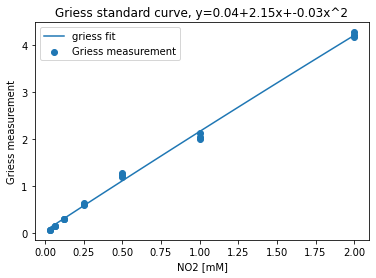

In [3]:
#fit griess assay model using standard curves
std_meta_fn = "data/standards_metadata.csv"
std_no2_fn = glob.glob("data/KC_NO2_KC_standard_20220512_220512_115800.csv")[0]
std_no2no3_fn = None
std_no2no3_540_fn = glob.glob("data/KC_standard_20220511_Absorbance_KC_NO2NO3_540_SCAN.CSV")[0]
std_no2no3_900_fn = glob.glob("data/KC_standard_20220511_Absorbance_KC_NO2NO3_900_SCAN.CSV")[0]
fit = gr.fit_griess(std_meta_fn,std_no2_fn,no2no3_fn=std_no2no3_fn,no2no3_540_fn=std_no2no3_540_fn,no2no3_900_fn=std_no2no3_900_fn)
[[no2_blank_dont_use,no2no3_blank_dont_use], g_fit_dont_use, v_fit] = fit
gr.plot_griess_fit(std_meta_fn,std_no2_fn,no2no3_fn=std_no2no3_fn,no2no3_540_fn=std_no2no3_540_fn,no2no3_900_fn=std_no2no3_900_fn)
plt.savefig('griess_standard_curve.png')

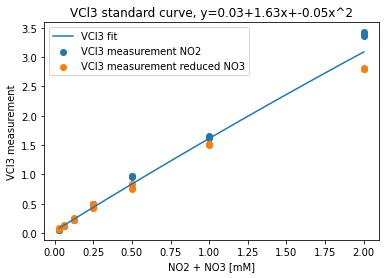

In [4]:
plt.cla()
gr.plot_vcl_fit(std_meta_fn,std_no2_fn,no2no3_fn=std_no2no3_fn,no2no3_540_fn=std_no2no3_540_fn,no2no3_900_fn=std_no2no3_900_fn)
plt.savefig('vcl3_standard_curve.png')

In [5]:
#manually input time points for measurements (in units of hr)
t = np.array([115, 397, 553, 1545, 2079, 72*60.0])/60.0 

#Load metabolite data and metadata
meta_fn = "data/plate1_metadata_cycle1.csv"
no2_fns = sorted(glob.glob("data/*NO2_*cycle2_*t*"))
no2no3_540_fns = sorted(glob.glob("data/*cycle2_*t*_*NO2NO3_540_SCAN.CSV"))
no2no3_900_fns = sorted(glob.glob("data/*cycle2_*t*_*NO2NO3_900_SCAN.CSV"))
[plate1_meta,plate1_no2,plate1_no3]=load_plate_timeseries_no_OD(meta_fn,no2_fns,no2no3_540_fns,no2no3_900_fns,fit,1)

#rename plate 1 info to be consistent with the rest of the code
merged_no2 = plate1_no2
merged_no3 = plate1_no3
merged_meta = plate1_meta

iterator = 0
for ID in merged_meta["strain_ID"]:
    iterator = iterator + 1
idx = (merged_meta["strain_ID"]=="blank") 

merged_no3.loc[idx]
no3_2mM_corr = merged_no3.loc[idx].median().values[0]/merged_no3.loc[idx].median().values.reshape(-1,1)

no2_2mM_corr = merged_no2.loc[idx].median().values[0]/merged_no2.loc[idx].median().values.reshape(-1,1)

#apply correction factors to account for evaporation
idx = (merged_meta["NO3_0"]==2) 

merged_no3.loc[idx] = merged_no3.loc[idx].multiply(np.transpose(no3_2mM_corr), axis='columns')
merged_no2.loc[idx] = merged_no2.loc[idx].multiply(np.transpose(no2_2mM_corr),axis='columns')


idx = (merged_meta["NO3_0"]==0)
merged_no3.loc[idx] = merged_no3.loc[idx].multiply(np.transpose(no3_2mM_corr), axis='columns')
merged_no2.loc[idx] = merged_no2.loc[idx].multiply(np.transpose(no2_2mM_corr),axis='columns')

idx = (merged_meta["strain_ID"]=="cells")
A = merged_no3.loc[idx].values
I = merged_no2.loc[idx].values




In [6]:
#List of unique strain_IDs
#print(merged_meta)
#print(merged_meta["OD0"] == 0.1)
#cycle 1 

from pprint import pprint
strain_IDs = np.setdiff1d(np.unique(merged_meta["strain_ID"]),['blank'])
all_experiments_100 = []

#For each strain_ID, identify wells corresponding to each experimental condition and put into experiments object
OD_filename = 'data/KC_OD600_Greiner_KC_NarG_NapA_co_vs_mono_cycle2_endpoint_1300_220513_131512.csv'
OD_meta       = pd.read_csv(meta_fn,index_col=0).dropna(how='all')  #import metadata
OD_data_frame = bd.read_abs_endpoint(OD_filename)
OD_data_frame = OD_data_frame[OD_data_frame.index.isin(OD_meta.index)]


dilution_factor = 8.0

prev_OD_filename = 'data/KC_OD600_Greiner_KC_NarG_NapA_co_vs_mono_cycle1_endpoint_1240pm_220510_124511.csv'
prev_OD_meta       = pd.read_csv(meta_fn,index_col=0).dropna(how='all')  #import metadata
prev_OD_data_frame = bd.read_abs_endpoint(prev_OD_filename)
prev_OD_data_frame = prev_OD_data_frame[prev_OD_data_frame.index.isin(OD_meta.index)]

for j in range(0,len(strain_IDs)):
    cond = np.array([[2,0,6],[2,0,7.3]])
    #load data into a list of experiment objects
    experiments = []
    for i in range(0,cond.shape[0]):
        blank_idx = (OD_meta["strain_ID"] == 'blank')
        blank_val = OD_data_frame[blank_idx].values
        prev_blank_val = prev_OD_data_frame[blank_idx].values
        OD_idx = ((OD_meta["strain_ID"]==strain_IDs[j]) & (OD_meta["NO3_0"]==cond[i,0]) & (OD_meta["NO2_0"]==cond[i,1]) & (OD_meta["pH"]==cond[i,2]))

        idx = ((merged_meta["strain_ID"]==strain_IDs[j]) & (merged_meta["NO3_0"]==cond[i,0]) & (merged_meta["NO2_0"]==cond[i,1])& (merged_meta["pH"]==cond[i,2]))
        #print(idx)
        ID = strain_IDs[j]
        A0 = cond[i,0]
        A = merged_no3.loc[idx].values
        I0 = cond[i,1]
        I = merged_no2.loc[idx].values
        pH = cond[i,2]
        N0 = (prev_OD_data_frame[OD_idx].values - np.mean(prev_blank_val))/dilution_factor 
        #N0 = 0.01
        Nend = OD_data_frame[OD_idx].values - np.mean(blank_val) 
        #Nend = None
        phen = 'Nar/Nir'
        succ_conc = 4
        experiments.append(dn.enrichment_experiment(ID, phen, N0, Nend, A0, A, I0, I, t, succ_conc, pH, endpoint_pH = None))
    
    all_experiments_100.append(experiments)
pickle_out = open("data/NapA_NarG_mvc_cycle2_experiments.pkl","wb")
pickle.dump(all_experiments_100, pickle_out)
pickle_out.close()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


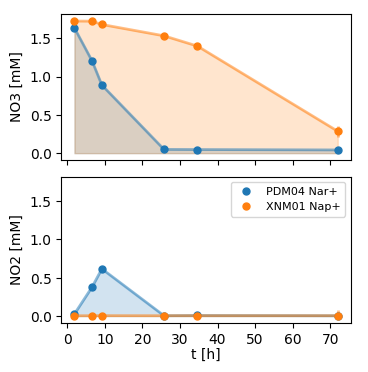

In [7]:
#now plot metabolite dynamics data to illustrate AUC

pH = 6
plt.style.use('default')
fig, axs = plt.subplots(2,1,sharex=True, sharey=True,figsize=(4,4))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'


alpha_dot = 1.0
linewidth = 2
markersize = 5
nar_strain = 'PDM04'
nap_strain = 'XNM01'

for k in range(len(IDs_orig)):
    #this outer loop goes through all strains, but we'll only plot one example of each genotype
    if IDs_orig[k] == nar_strain or IDs_orig[k] == nap_strain: 
        idx = (OD_meta["strain_ID"] == IDs_orig[k]) & (OD_meta["pH"] == pH)
        if genotypes_orig[k] == 'NarG':
            alpha = 0.5
            color = 'tab:blue'
            label = nar_strain+ ' Nar+'
        elif genotypes_orig[k] == 'NapA':
            alpha = 0.5
            color = 'tab:orange'
            label = nap_strain+ ' Nap+'
        else:
            raise NameError('genotype not found')        
        for experiments in all_experiments_100:
            for experiment in experiments:
                if experiment.ID == IDs_orig[k]  and experiment.pH == pH:
                    axs[0].plot(experiment.t, np.mean(experiment.A[:], axis = 0), '-', linewidth = linewidth, markersize = markersize, color = color, alpha = alpha)
                    axs[0].fill_between(experiment.t, np.mean(experiment.A[:], axis = 0), color = color, alpha = 0.2)
                    axs[0].plot(experiment.t, np.mean(experiment.A[:], axis = 0), 'o', linewidth = linewidth, markersize = markersize, color = color, alpha = alpha_dot)

                    axs[0].vlines(experiment.t, np.mean(experiment.A[:], axis = 0)-np.std(experiment.A[:], axis = 0),np.mean(experiment.A[:], axis = 0)+np.std(experiment.A[:], axis = 0), linewidth = linewidth, color = color, alpha = alpha)
                    axs[1].plot(experiment.t, np.mean(experiment.I[:], axis = 0), '-', linewidth = linewidth, markersize = markersize, color = color, alpha = alpha)
                    axs[1].fill_between(experiment.t, np.mean(experiment.I[:], axis = 0), color = color, alpha = 0.2)

                    axs[1].plot(experiment.t, np.mean(experiment.I[:], axis = 0), 'o', linewidth = linewidth, markersize = markersize, color = color, alpha = alpha_dot, label = label)

                    axs[1].vlines(experiment.t, np.mean(experiment.I[:], axis = 0)-np.std(experiment.I[:], axis = 0),np.mean(experiment.I[:], axis = 0)+np.std(experiment.A[:], axis = 0), linewidth = linewidth, color = color, alpha = alpha)
                
axs[0].set_ylabel('NO3 [mM]')
axs[1].set_ylabel('NO2 [mM]')
axs[1].legend()
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

plt.xlabel("t [h]", fontsize = 10.0)


fig.tight_layout()
plt.savefig('fig_7_rep_met_dynamics.png')
plt.savefig('fig_7_rep_met_dynamics.svg')


plt.show()



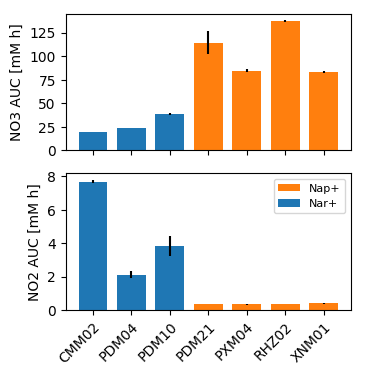

In [8]:
#calculate and plot AUC 

pH = 6
plt.style.use('default')
fig, axs = plt.subplots(2,1,sharex=True, sharey=False,figsize=(4,4))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'


alpha_dot = 1.0
linewidth = 2
markersize = 5
bar_width = 0.75

nar_idx = 0
nap_idx = 0

for k in range(len(IDs_orig)):
    idx = (OD_meta["strain_ID"] == IDs_orig[k]) & (OD_meta["pH"] == pH)
    if genotypes_orig[k] == 'NarG':
        alpha = 0.5
        color = 'tab:blue'
        delta = 0.25
        label = 'Nar+'
        idx = nar_idx
        nar_idx = nar_idx+1
    elif genotypes_orig[k] == 'NapA':
        alpha = 0.5
        color = 'tab:orange'
        delta = -0.25
        label = 'Nap+'
        idx = 3+nap_idx
        nap_idx = nap_idx+1
    else:
        raise NameError('genotype not found')        
    for experiments in all_experiments_100:
        for experiment in experiments:
            if experiment.ID == IDs_orig[k]  and experiment.pH == pH:
                AUC_A = []
                AUC_I = []
                for j in range(len(experiment.A[:,0])):
                    AUC_A.append(np.trapz(experiment.A[j,:], x = experiment.t))
                    AUC_I.append(np.trapz(experiment.I[j,:], x = experiment.t))

                axs[0].bar(idx, np.mean(AUC_A), width = bar_width, yerr = np.std(AUC_A), color = color, ecolor = 'k')
                if k == 0 or k==1:
                    axs[1].bar(idx, np.mean(AUC_I), width = bar_width, yerr = np.std(AUC_I), color = color, ecolor = 'k', label = label)                            
                else:
                    axs[1].bar(idx, np.mean(AUC_I), width = bar_width, yerr = np.std(AUC_I), color = color, ecolor = 'k')



axs[0].set_ylabel('NO3 AUC [mM h]')
axs[1].set_ylabel('NO2 AUC [mM h]')
axs[1].legend()
axs[1].set_xticks(range(len(IDs_orig)))
axs[1].set_xticklabels(labels=IDs_orig)
plt.setp(axs[1].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)


fig.tight_layout()
plt.savefig('fig_7_AUC_monos.png')
plt.savefig('fig_7_AUC_monos.svg')


plt.show()
